# Breeding Site Distribution of Nakhon-Si-Thammarat in District Level

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from plotly import tools
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import plotly.graph_objs as go
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import json
import itertools

from tqdm import tqdm
from copy import deepcopy
from scipy.stats.stats import pearsonr, spearmanr
from shapely.geometry import Polygon
from collections import Counter

sns.set(color_codes=True)

data_dir = os.path.join('..','..','data')

## 0. Helper Function

In [12]:
def get_detect(df_detect, addrcode, columns=None):
    if columns is None:
        detect = round(df_detect.loc[df_detect['addrcode'] == addrcode].mean()['total'], 2)
    else:
        # Breeding Site Feature
        detect = df_detect.loc[df_detect['addrcode'] == addrcode][columns].copy()
    return detect

def get_area(df_area, addrcode):
    area = round(df_area.loc[df_area['addrcode'] == addrcode]['area'].mean(), 2)
    return area

def get_population(df_population, addrcode):
    population = round(df_population.loc[df_population['addrcode'] == addrcode]['population'].mean(), 2)
    return population

def get_gsv_coverage(df_gsv_coverage, addrcode):
    coverage = df_gsv_coverage.loc[df_gsv_coverage['addrcode'] == addrcode]['image_area'].mean()
    return coverage

def get_dict_info(df_dictionary, addrcode):
    dict_info = df_dictionary.loc[df_dictionary['addrcode'] == addrcode]
    return dict_info

def get_percentage(part, whole):
    return 100 * float(part)/float(whole)

def get_hectare(area):
    return area*111111*0.0001

## 1. Load Data

In [13]:
# Load Detected Breeding Sites
df_detect = pd.read_csv(os.path.join(data_dir,'breeding-sites','csv','addrcode-index','detection.csv')) 
df_detect['date'] = pd.to_datetime(df_detect['date'], format='%Y-%m')
df_detect['addrcode'] = df_detect['addrcode'].astype('str')
df_detect['addrcode'] = df_detect['addrcode'].str[:-2]
df_detect = df_detect.groupby(['addrcode']).sum()
df_detect = df_detect.reset_index()
df_detect.head(1)
# print('Total data points:',len(df_detect))

# Area
df_area = pd.read_csv(os.path.join(data_dir,'shapefiles','csv','subdistricts-area.csv')) 
df_area['addrcode'] = df_area['addrcode'].astype('str')
df_area['addrcode'] = df_area['addrcode'].str[:-2]
df_area = df_area.groupby(['addrcode']).sum()
df_area = df_area.reset_index()
df_area.head(1)
# print('Total data points:',len(df_area))

# Population 
df_population = pd.read_csv(os.path.join(data_dir,'population','addrcode-index','population.csv')) 
df_population['addrcode'] = df_population['addrcode'].astype('str')
df_population['addrcode'] = df_population['addrcode'].str[:-2]
df_population = df_population.groupby(['addrcode']).sum()
df_population = df_population.reset_index()
df_population.head(1)
# print('Total data points:',len(df_population))

df_dictionary = pd.read_csv(os.path.join(data_dir,'shapefiles','csv','addrcode-dictionary.csv')) 
df_dictionary['addrcode'] = df_dictionary['addrcode'].astype('str')
df_dictionary['addrcode'] = df_dictionary['addrcode'].str[:-2]
df_dictionary = df_dictionary.drop(['subdistrict_th','subdistrict_en','district_code','province_code','LAT','LONG','Population'], axis=1)
df_dictionary = df_dictionary.drop_duplicates()
df_dictionary.head(1)

df_gsv_coverage = pd.read_csv(os.path.join(data_dir,'shapefiles','csv','gsv-coverage.csv')) 
df_gsv_coverage['addrcode'] = df_gsv_coverage['addrcode'].astype('str')
df_gsv_coverage['addrcode'] = df_gsv_coverage['addrcode'].str[:-2]
df_gsv_coverage = df_gsv_coverage.groupby(['addrcode']).sum()
df_gsv_coverage = df_gsv_coverage.reset_index()
df_gsv_coverage.head(1)

,addrcode,bin,bowl,bucket,cup,jar,pottedplant,tire,vase,total
0,1001,167,87,509,73,22,1543,101,25,2527


,addrcode,area
0,1001,49.81


,addrcode,population
0,1001,52522


,addrcode,district_th,district_en,province_th,province_en
0,1001,พระนคร,Phra Nakhon,กรุงเทพมหานคร,Bangkok


,addrcode,land_area,image_area
0,1001,49.81,69.02


In [31]:
brd_sites=['bin','bowl','bucket','cup','jar','pottedplant','tire','vase']
distribution_entry = []
p = 0
for addrcode in df_detect['addrcode'].unique():
    
    if str(addrcode)[:2] == '80':
        
        dict_info = get_dict_info(df_dictionary, addrcode)
        district = get_dict_info(df_dictionary, addrcode).iloc[0]['district_en']
        land_area = get_hectare(get_area(df_area, addrcode))
        image_area =  get_hectare(get_gsv_coverage(df_gsv_coverage, addrcode))
        population = get_population(df_population, addrcode)
        bs_total = get_detect(df_detect, addrcode)
        bs_classes = get_detect(df_detect, addrcode, brd_sites)
        
        if np.isnan(population): continue

        distribution_entry.append([
            district,
            land_area,
            image_area,
            population,
            bs_total,
            bs_total/land_area,
            bs_total/image_area,
            bs_total/population,
            get_percentage(bs_classes.jar, bs_total),
            get_percentage(bs_classes.bucket, bs_total),
            get_percentage(bs_classes.pottedplant, bs_total),
            get_percentage(bs_classes.tire, bs_total),
            get_percentage(bs_classes.bin, bs_total),
            get_percentage(bs_classes.bowl, bs_total),
            get_percentage(bs_classes.cup, bs_total),
            get_percentage(bs_classes.vase, bs_total)
        ])
        
df_distribution = pd.DataFrame.from_records(
    distribution_entry, 
    columns=[
        'District',
        'Area (ha)',
        'Area of Images (ha)',
        'Population',
        'No. of BS',
        'BS/ha land',
        'BS/ha image',
        'BS/person',
        'Jar (%)',
        'Bucket (%)',
        'Potted plant (%)',
        'Tire (%)',
        'Bin (%)',
        'Bowl (%)',
        'Cup (%)',
        'Vase (%)'
    ])
df_distribution = df_distribution.round(2)
df_distribution[['No. of BS','Population']] = df_distribution[['No. of BS','Population']].astype(int)
df_distribution.head()
df_distribution.to_csv('Nakhon-dist.csv')

,District,Area (ha),Area of Images (ha),Population,No. of BS,BS/ha land,BS/ha image,BS/person,Jar (%),Bucket (%),Potted plant (%),Tire (%),Bin (%),Bowl (%),Cup (%),Vase (%)
0,Mueang Nakhon Si Thammarat,56460.94,11149.66,271330,19915,0.35,1.79,0.07,1.78,41.91,36.77,6.30,11.77,0.57,0.81,0.10
1,Phrom Khiri,25009.86,1851.33,37513,2099,0.08,1.13,0.06,0.52,39.40,39.45,5.72,13.91,0.57,0.33,0.10
2,Lan Saka,34954.41,1524.44,40900,1479,0.04,0.97,0.04,2.10,46.79,31.58,5.07,13.79,0.34,0.27,0.07
3,Chawang,43949.84,2764.89,67293,3650,0.08,1.32,0.05,1.81,44.03,32.49,6.30,13.89,0.41,1.04,0.03
4,Phipun,50118.06,1186.33,29226,1812,0.04,1.53,0.06,1.77,51.27,32.62,6.07,6.40,0.72,0.77,0.39


## 2. Statistics

In [33]:
df_distribution.describe().round(2)
df_distribution.describe().round(2).to_csv('Nakhon-dist-stat.csv')

,Area (ha),Area of Images (ha),Population,No. of BS,BS/ha land,BS/ha image,BS/person,Jar (%),Bucket (%),Potted plant (%),Tire (%),Bin (%),Bowl (%),Cup (%),Vase (%)
count,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00,23.00
mean,43564.47,3513.65,68914.35,3678.65,0.08,0.99,0.05,2.70,44.56,31.66,9.98,9.82,0.57,0.62,0.09
std,20868.50,2470.37,57376.23,4017.14,0.07,0.33,0.02,1.89,9.95,5.61,4.49,4.82,0.25,0.22,0.09
min,15106.54,1014.67,19177.00,839.00,0.02,0.60,0.02,0.52,27.85,19.49,5.07,3.36,0.16,0.22,0.00
25%,26335.70,1732.83,31578.00,1656.50,0.04,0.69,0.04,1.45,38.98,28.46,6.30,6.90,0.40,0.50,0.04
50%,43526.29,2764.89,43588.00,2276.00,0.07,0.96,0.05,2.02,44.03,32.49,9.44,9.62,0.54,0.62,0.09
75%,55126.39,4934.50,84269.00,3998.50,0.09,1.22,0.06,3.28,49.73,34.48,10.85,11.89,0.70,0.78,0.12
max,92218.91,11149.66,271330.00,19915.00,0.35,1.79,0.08,7.25,65.91,43.84,21.48,23.03,1.39,1.04,0.39


## 3. Boxplot

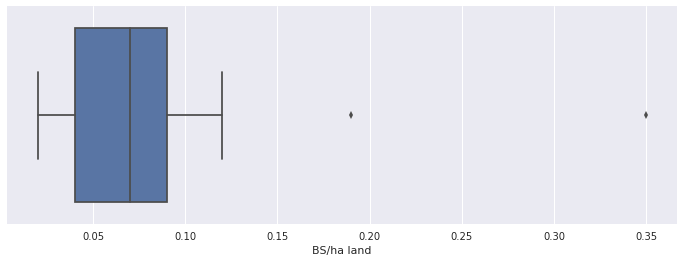

In [26]:
sns.set()
plt.figure(figsize=(12,4))
plt.style.use(['seaborn-notebook'])
sns.boxplot(df_distribution['BS/ha land'])

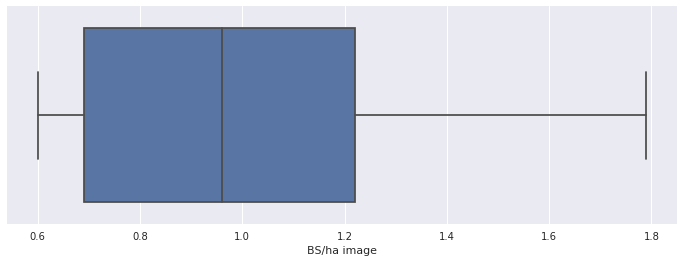

In [27]:
plt.figure(figsize=(12,4))
sns.boxplot(df_distribution['BS/ha image'])

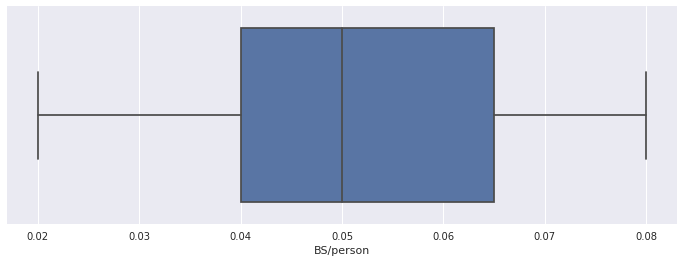

In [28]:
plt.figure(figsize=(12,4))
sns.boxplot(df_distribution['BS/person'])

## 4. Distribution Plot

Text(0.5,1,'Nakhon-Districts')

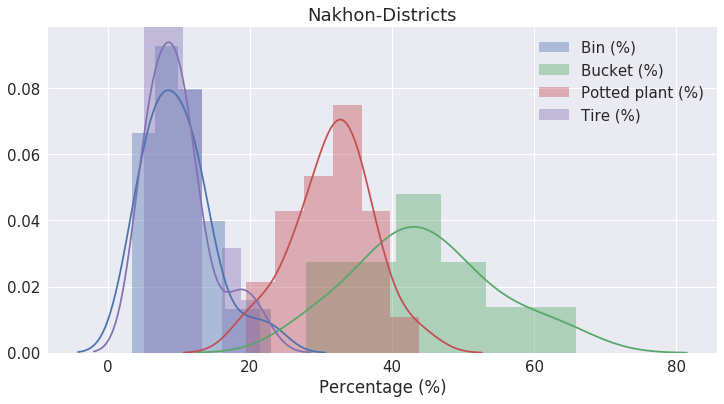

In [35]:
sns.set(font_scale=1.5)
plt.figure(figsize=(12,6))
plt.title('Nakhon-Districts')
sns.distplot(df_distribution['Bin (%)'], label="Bin (%)", axlabel='Percentage (%)')
sns.distplot(df_distribution['Bucket (%)'], label="Bucket (%)", axlabel='Percentage (%)')
sns.distplot(df_distribution['Potted plant (%)'], label="Potted plant (%)", axlabel='Percentage (%)')
sns.distplot(df_distribution['Tire (%)'], label="Tire (%)", axlabel='Percentage (%)')
plt.legend()


Text(0.5,1,'Nakhon-Districts')

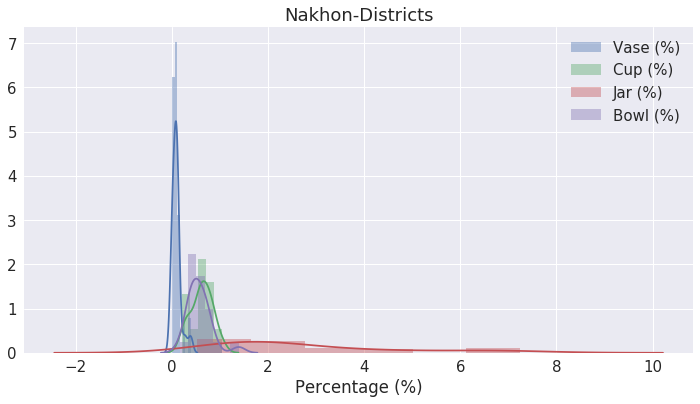

In [34]:
sns.set(font_scale=1.5)
plt.figure(figsize=(12,6))
plt.title('Nakhon-Districts')
sns.distplot(df_distribution['Vase (%)'], label="Vase (%)", axlabel='Percentage (%)')
sns.distplot(df_distribution['Cup (%)'], label="Cup (%)", axlabel='Percentage (%)')
sns.distplot(df_distribution[['Jar (%)']], label="Jar (%)", axlabel='Percentage (%)')
sns.distplot(df_distribution['Bowl (%)'], label="Bowl (%)", axlabel='Percentage (%)')
plt.legend()